# Exploratory Data Analysis

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import pylab as pl

df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]

## NPI representation: total, by country, by region

Text(0.5, 1.0, 'Number of days that each NPI is active in any region of any country')

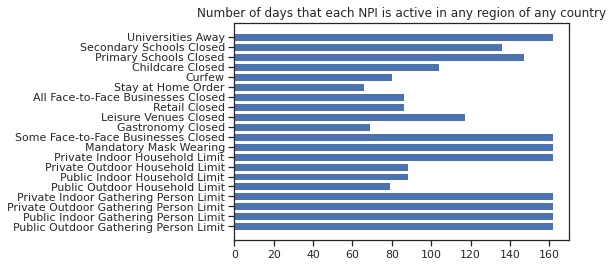

In [22]:
def count_active_days(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    return len(np.unique(df['Date'][non_zero_rows]))
active_days = [count_active_days(npi) for npi in CMs]
plt.barh(y=CMs, width=active_days)
plt.title('Number of days that each NPI is active in any region of any country')


<AxesSubplot:title={'center':'Number of days each NPI is active in any region of each specific country'}, xlabel='CMs'>

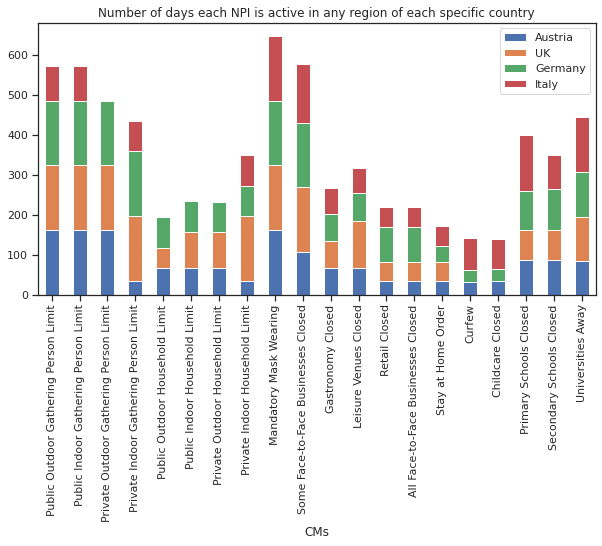

In [23]:
def count_active_days_country(npi):
    non_zero_rows = [ind for ind in range(df.shape[0]) if df[npi][ind] != 0]
    active_inds = []
    for country in np.unique(df['Country']):
        active_ind = [ind for ind in non_zero_rows if df['Country'][ind] == country]
        count = len(np.unique(df['Date'][active_ind]))
        active_inds.append(count)
    return active_inds
active_days_country = [count_active_days_country(npi) for npi in CMs]
active_days_country = pd.DataFrame((active_days_country))
active_days_country.columns = ['Austria', 'UK', 'Germany', 'Italy']
normalised_country = active_days_country.div(active_days_country.sum(axis=1), axis=0)
active_days_country['CMs'] = CMs
active_days_country.set_index('CMs').plot(kind='bar', stacked=True, title='Number of days each NPI is active in any region of each specific country', figsize = (10,5))

Text(0.5, 1.0, 'Proportion of active days attributable to each country')

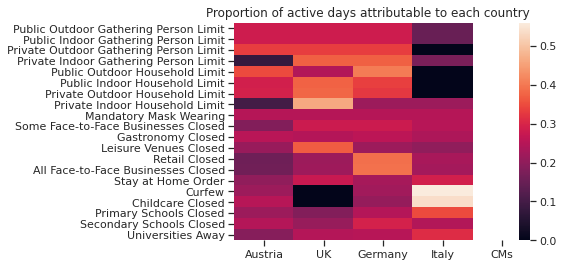

In [24]:
sns.heatmap(normalised_country, xticklabels = active_days_country.columns, yticklabels = CMs).set_title('Proportion of active days attributable to each country')

In [25]:
def count_active_days_region(npi, country):
    df_country = df[df['Country']==country]
    #non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
    non_zero_rows = df_country[df_country[npi] != 0]
    regions = np.unique(df_country['Area'])
    active_inds = []
    for region in regions:
        #active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
        #active_ind = df_country.loc[df_country['Area'] == region]
        active_rows = non_zero_rows[non_zero_rows['Area']==region]
        count = active_rows.shape[0]
        active_inds.append(count)
    return regions, active_inds

active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]

# summing up counts from the regions for each npi:
region_counts_uk = [sum(i) for i in active_days_uk]
region_counts_de = [sum(i) for i in active_days_de]
region_counts_at = [sum(i) for i in active_days_at]
region_counts_it = [sum(i) for i in active_days_it]

In [26]:
# region_counts = pd.DataFrame((CMs, region_counts_at, region_counts_uk,
# region_counts_de, region_counts_it)).T
# region_counts.columns = ['CMs', 'Austria', 'UK', 'Germany', 'Italy']
# region_counts.set_index('CMs').plot(kind='bar', stacked=True, title='Coloured bar length is the sum of days across the country\'s regions that the NPI is active', figsize = (10,5))

In [27]:
def plot_region_contribution_heatmap(active_days_specific_country, country):
    active_days_specific_country = pd.DataFrame(active_days_specific_country)
    active_days_specific_country.columns = count_active_days_region(CMs[0], country)[0]
    active_days_specific_country.index = CMs
    active_days_normalised = active_days_specific_country.div(active_days_specific_country.sum(axis=1), axis=0)
    return sns.heatmap(active_days_normalised, xticklabels = active_days_specific_country.columns, yticklabels = CMs).set_title('Proportion of active days in '+ country + ' attributable to each constituent region')

Text(0.5, 1.0, 'Proportion of active days in England attributable to each constituent region')

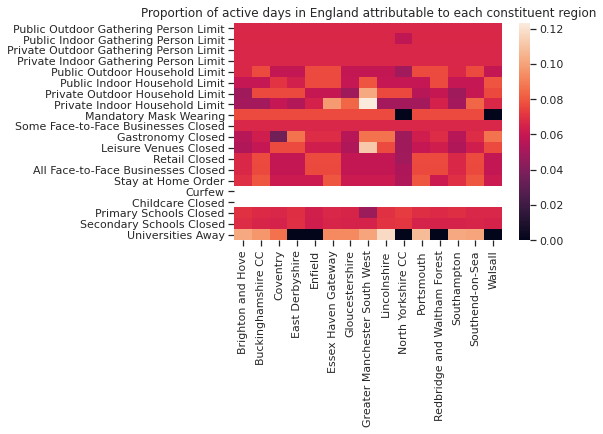

In [28]:
plot_region_contribution_heatmap(active_days_uk, 'England')

Text(0.5, 1.0, 'Proportion of active days in Germany attributable to each constituent region')

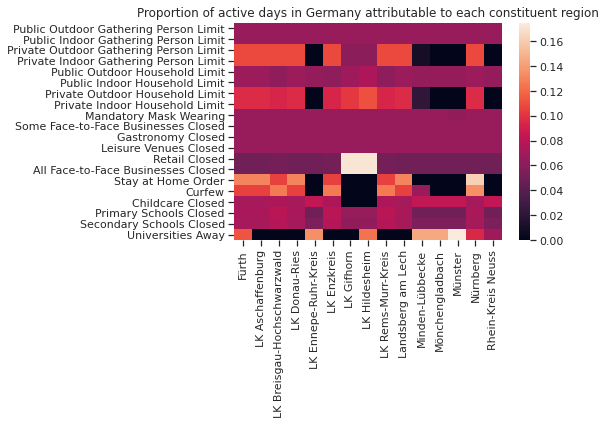

In [29]:
plot_region_contribution_heatmap(active_days_de, 'Germany')

Text(0.5, 1.0, 'Proportion of active days in Austria attributable to each constituent region')

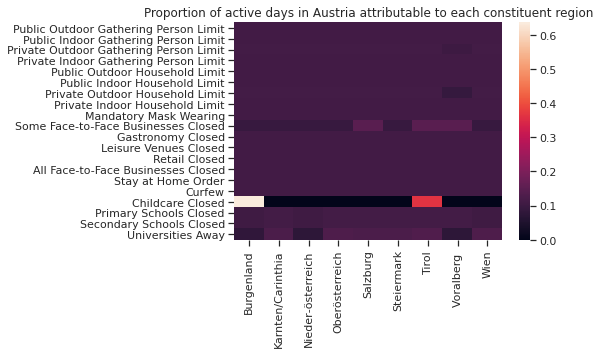

In [30]:
plot_region_contribution_heatmap(active_days_at, 'Austria')

Text(0.5, 1.0, 'Proportion of active days in Italy attributable to each constituent region')

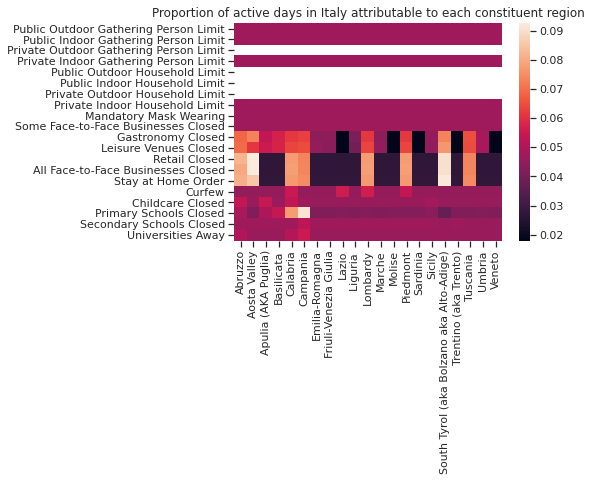

In [31]:
plot_region_contribution_heatmap(active_days_it, 'Italy')

In [32]:
len(np.unique(df['Area']))
#total number of days:
162*len(np.unique(df['Area']))

9720

## Thresholding

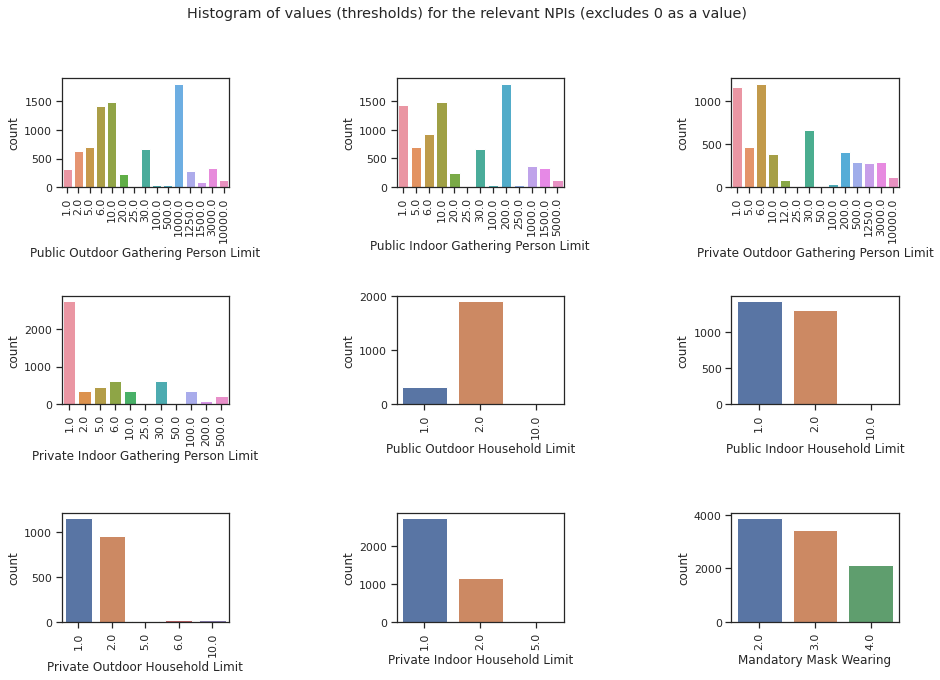

In [33]:
thresholding_CMs = [CM for CM in CMs if len(np.unique(df[CM]))>2]
df_reduced = df[df!=0]
df_thresholds = df_reduced[thresholding_CMs]
fig = plt.figure(figsize=((15,10)))
fig.subplots_adjust(hspace=1, wspace=1)
for i in range(len(thresholding_CMs)):
    ax = fig.add_subplot(3, 3, i+1)
    plt.xticks(rotation=90)
    sns.countplot(x = thresholding_CMs[i], data=df_thresholds, ax=ax)
pl.suptitle("Histogram of values (thresholds) for the relevant NPIs (excludes 0 as a value)")
plt.show()

## Conditional activation


In [34]:
def get_active_dates_region(data, npi):
    non_zero_dates = data['Date'][data[npi] != 0]
    return non_zero_dates

def intersect_npi_active_dates_region(active_days_1, active_days_2):
    return set(active_days_1).intersection(set(active_days_2))

def proportional_activation_region(active_days_1, active_days_2):
    number_of_active_days = len(active_days_1)
    if number_of_active_days == 0: return float('nan')
    number_of_jointly_active_days = len(intersect_npi_active_dates_region(active_days_1, active_days_2))
    return number_of_jointly_active_days/number_of_active_days

def activation_difference_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2))

def only_one_active_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2)) + len(set(active_days_2) - set(active_days_1))

def find_conditional_activations(country):
    regions = np.unique(df['Area'][df['Country']==country])
    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    count = 0
    for region in regions:
        data = df[df['Area']==region]
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                active_days_1 = get_active_dates_region(data, CMs[i])
                active_days_2 = get_active_dates_region(data, CMs[j])
                if count == 0:
                    proportional_activations[i, j] = [proportional_activation_region(active_days_1, active_days_2)]
                    activation_differences[i, j] = [activation_difference_region(active_days_1, active_days_2)]
                    single_activations[i, j] = [only_one_active_region(active_days_1, active_days_2)]
                else:
                    proportional_activations[i, j].append(proportional_activation_region(active_days_1, active_days_2))
                    activation_differences[i, j].append(activation_difference_region(active_days_1, active_days_2))
                    single_activations[i, j].append(only_one_active_region(active_days_1, active_days_2))
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.mean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

def find_conditional_activations_total():

    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)

    countries = np.unique(df['Country'])
    count = 0
    for country in countries:
        prop, act, single = find_conditional_activations(country)
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                if count == 0:
                    proportional_activations[i, j] = [prop[i,j]]
                    activation_differences[i, j] = [act[i,j]]
                    single_activations[i, j] = [single[i,j]]
                else:
                    proportional_activations[i, j].append(prop[i,j])
                    activation_differences[i, j].append(act[i,j])
                    single_activations[i, j].append(single[i,j])
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.nanmean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

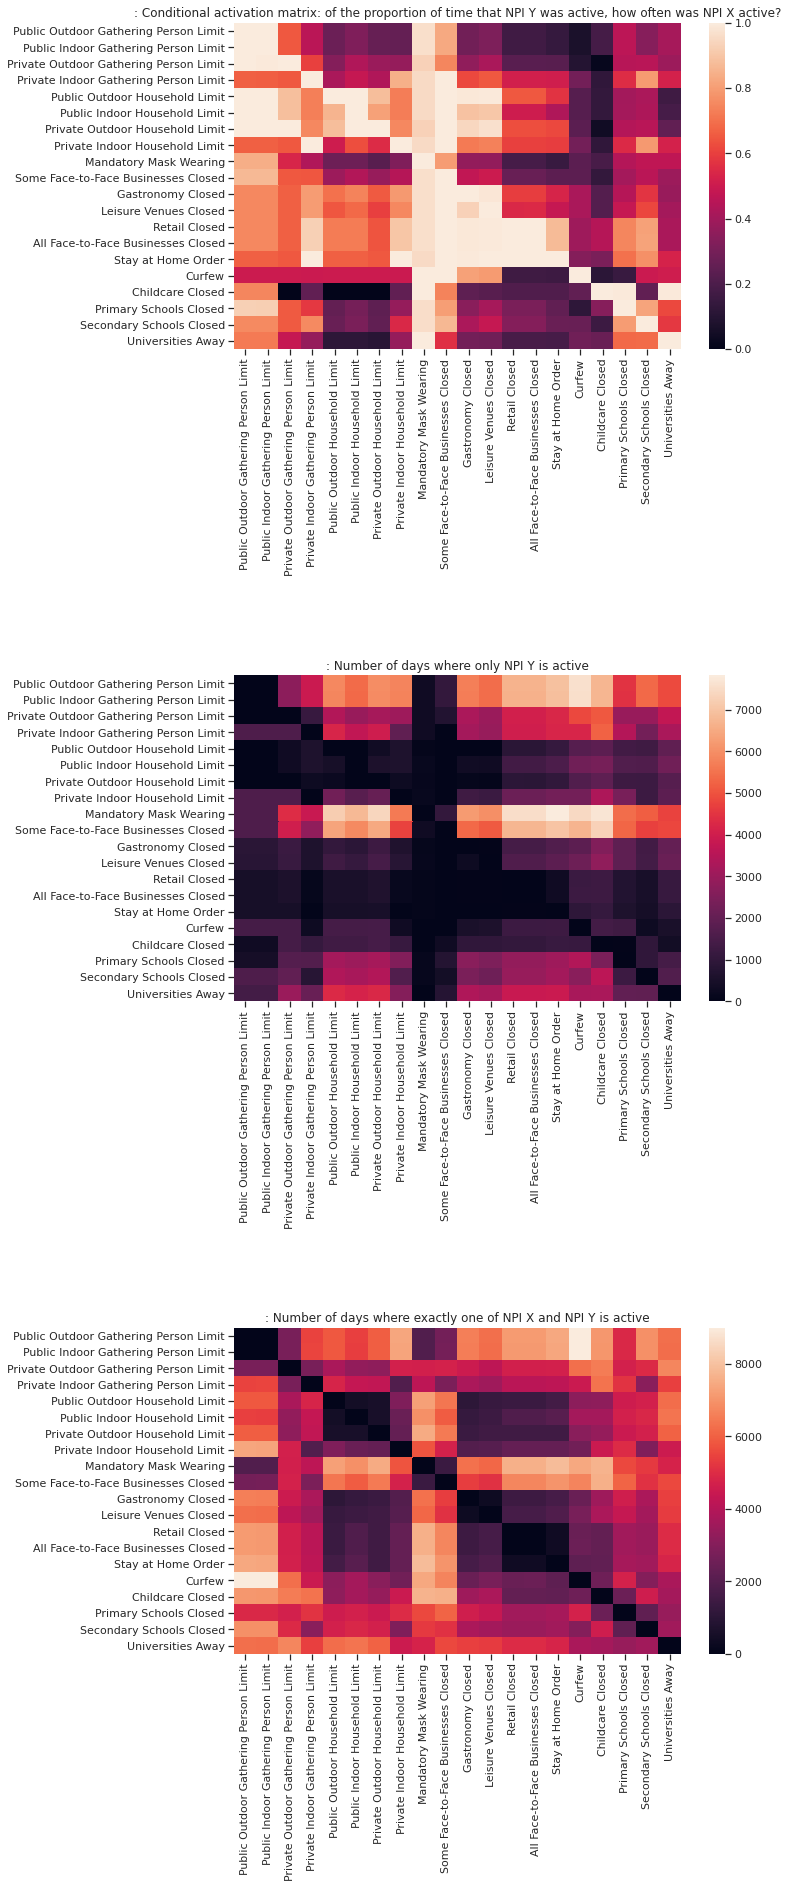

In [35]:
prop, act, single = find_conditional_activations_total()
fig = plt.figure(figsize=((10,30)))
fig.subplots_adjust(hspace=1)
ax = fig.add_subplot(3, 1, 1)
sns.heatmap(pd.DataFrame(prop, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(': Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
ax = fig.add_subplot(3, 1, 2)
sns.heatmap(pd.DataFrame(act, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(': Number of days where only NPI Y is active')
ax = fig.add_subplot(3, 1, 3)
sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(': Number of days where exactly one of NPI X and NPI Y is active')
plt.show()

In [36]:
def conditional_activation_plotter(country):
    prop, act, single = find_conditional_activations(country)
    fig = plt.figure(figsize=((10,30)))
    fig.subplots_adjust(hspace=1)
    ax = fig.add_subplot(3, 1, 1)
    sns.heatmap(pd.DataFrame(prop, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Conditional activation matrix: of the proportion of time that NPI Y was active, how often was NPI X active?')
    ax = fig.add_subplot(3, 1, 2)
    sns.heatmap(pd.DataFrame(act, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Number of days where only NPI Y is active')
    ax = fig.add_subplot(3, 1, 3)
    sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title(country + ': Number of days where exactly one of NPI X and NPI Y is active')
    plt.show()


### Austria

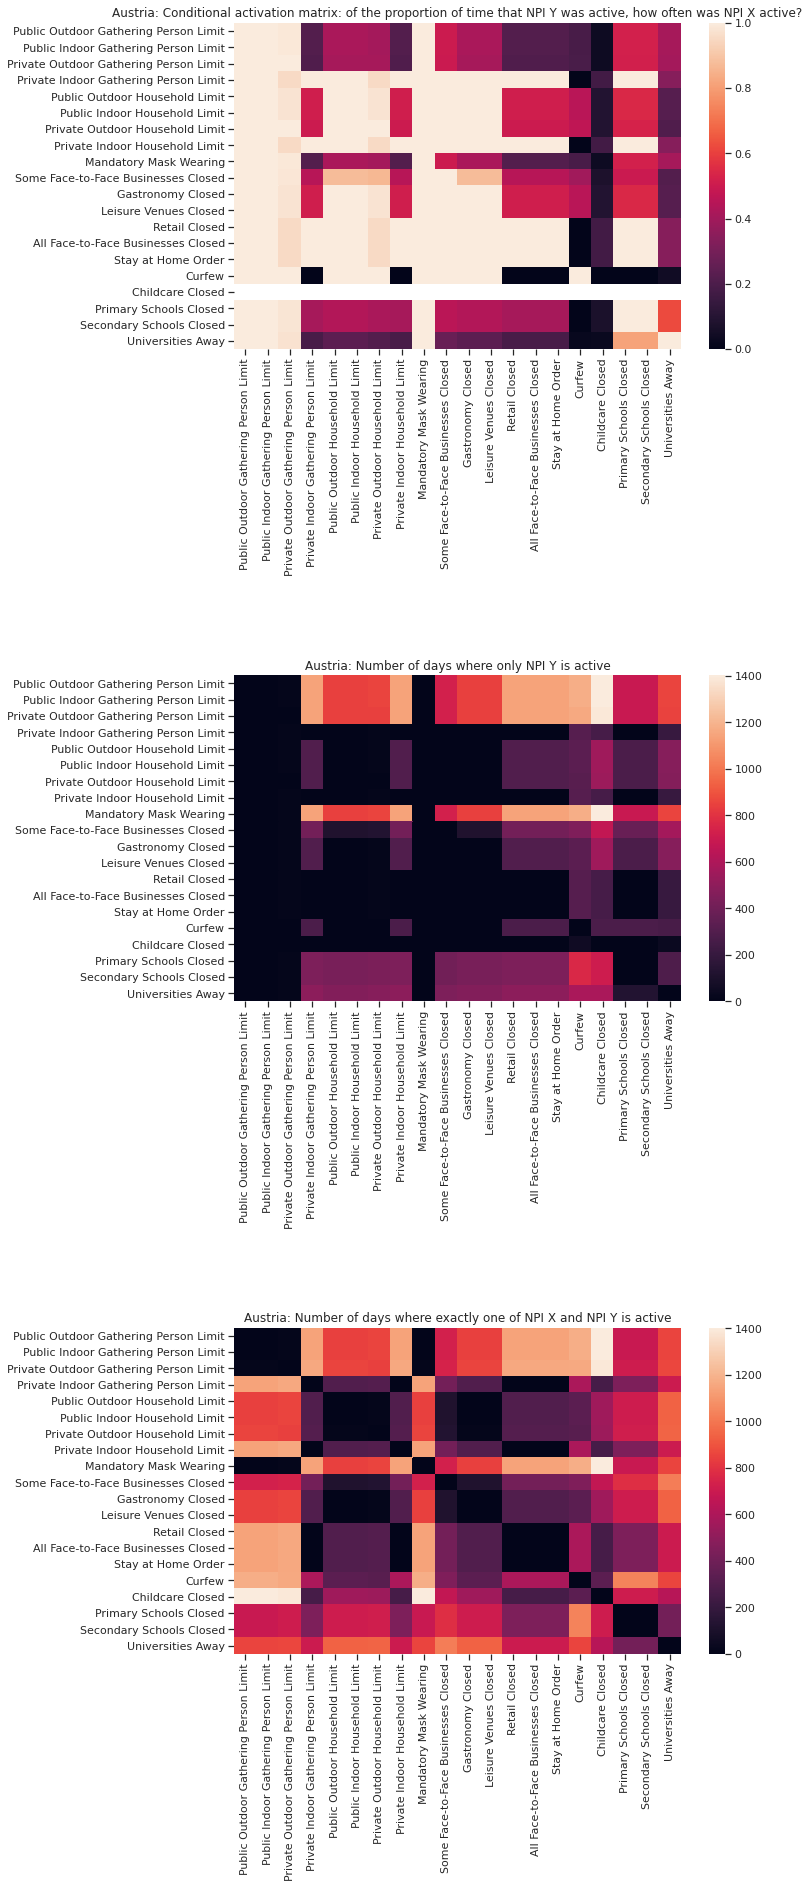

In [37]:
conditional_activation_plotter('Austria')

### England

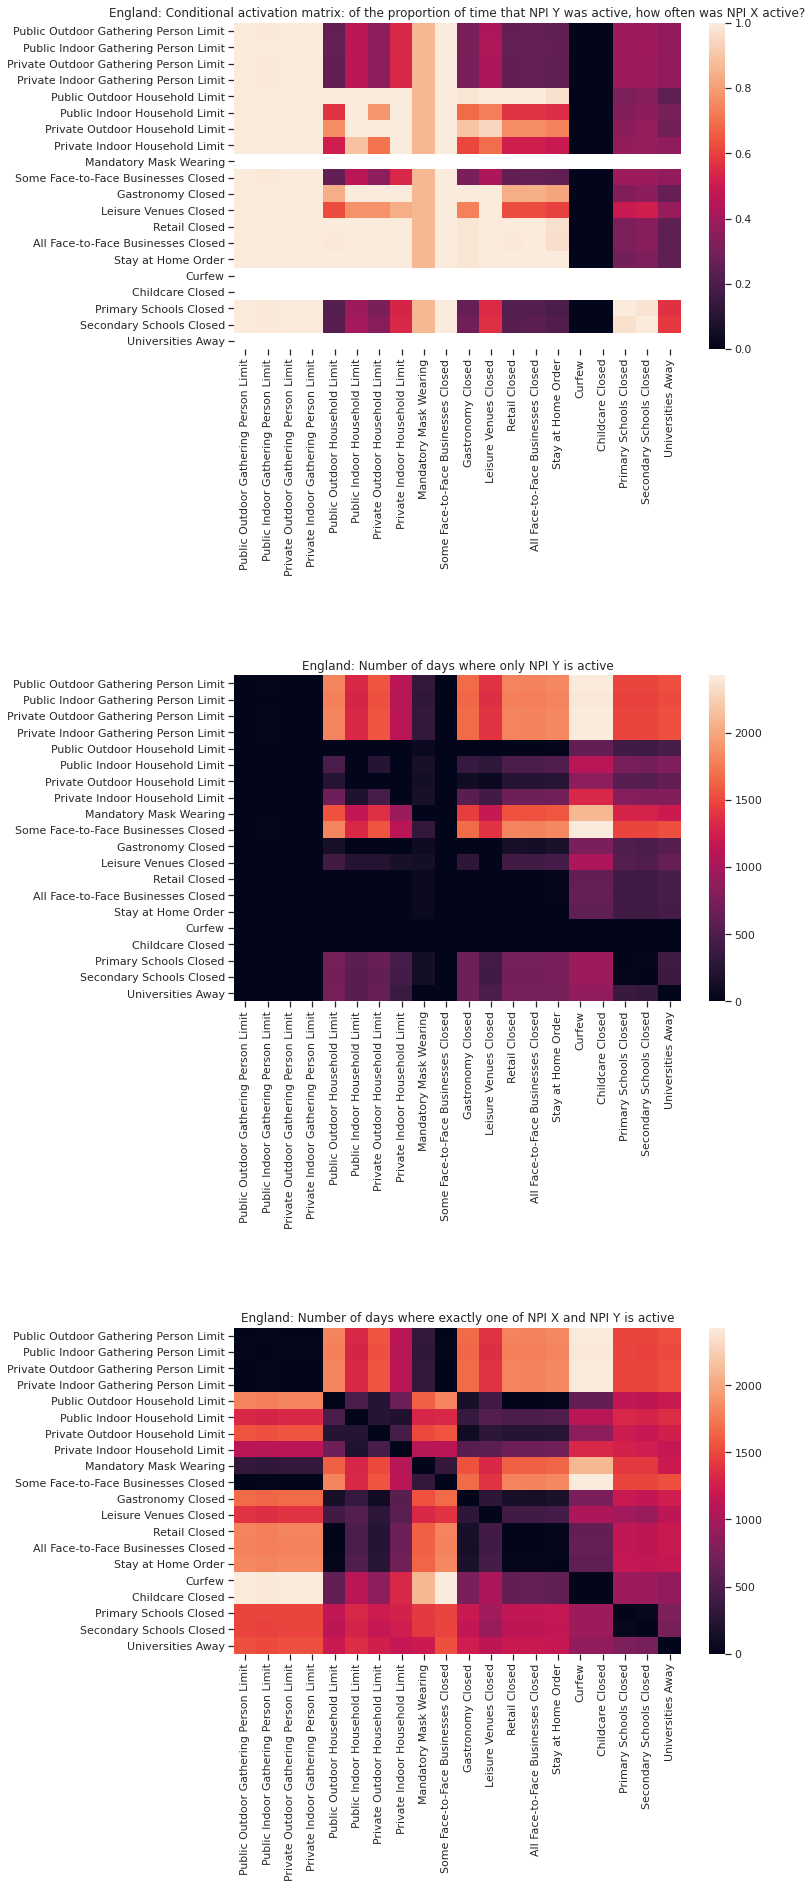

In [38]:
conditional_activation_plotter('England')

### Germany

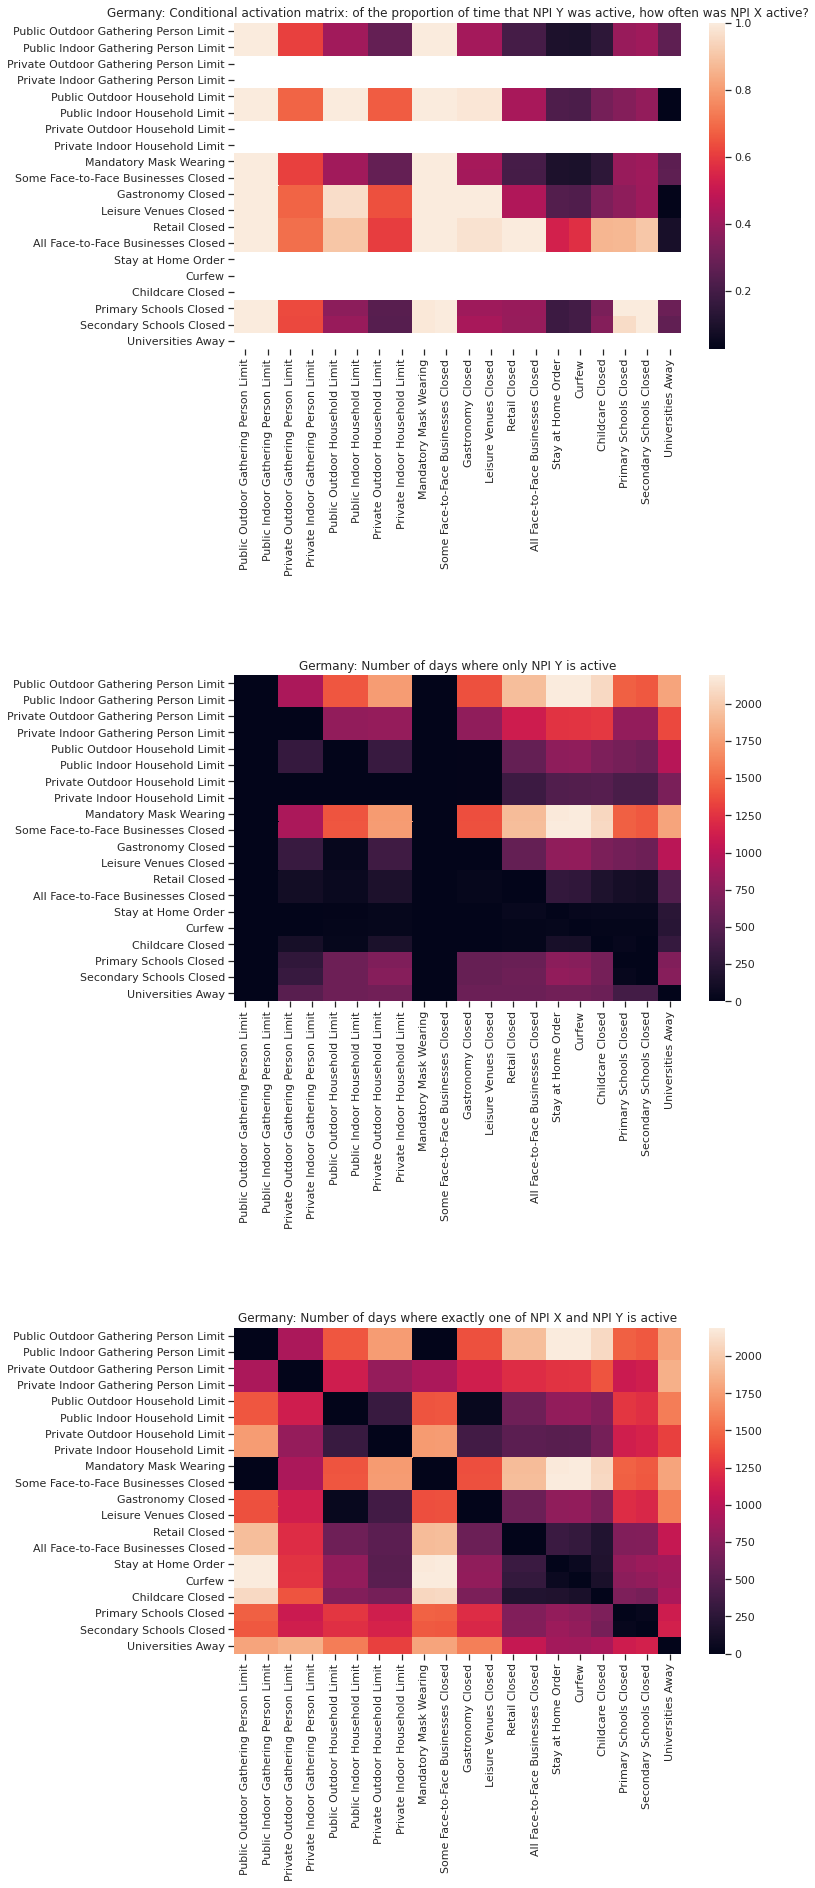

In [39]:
conditional_activation_plotter('Germany')

### Italy

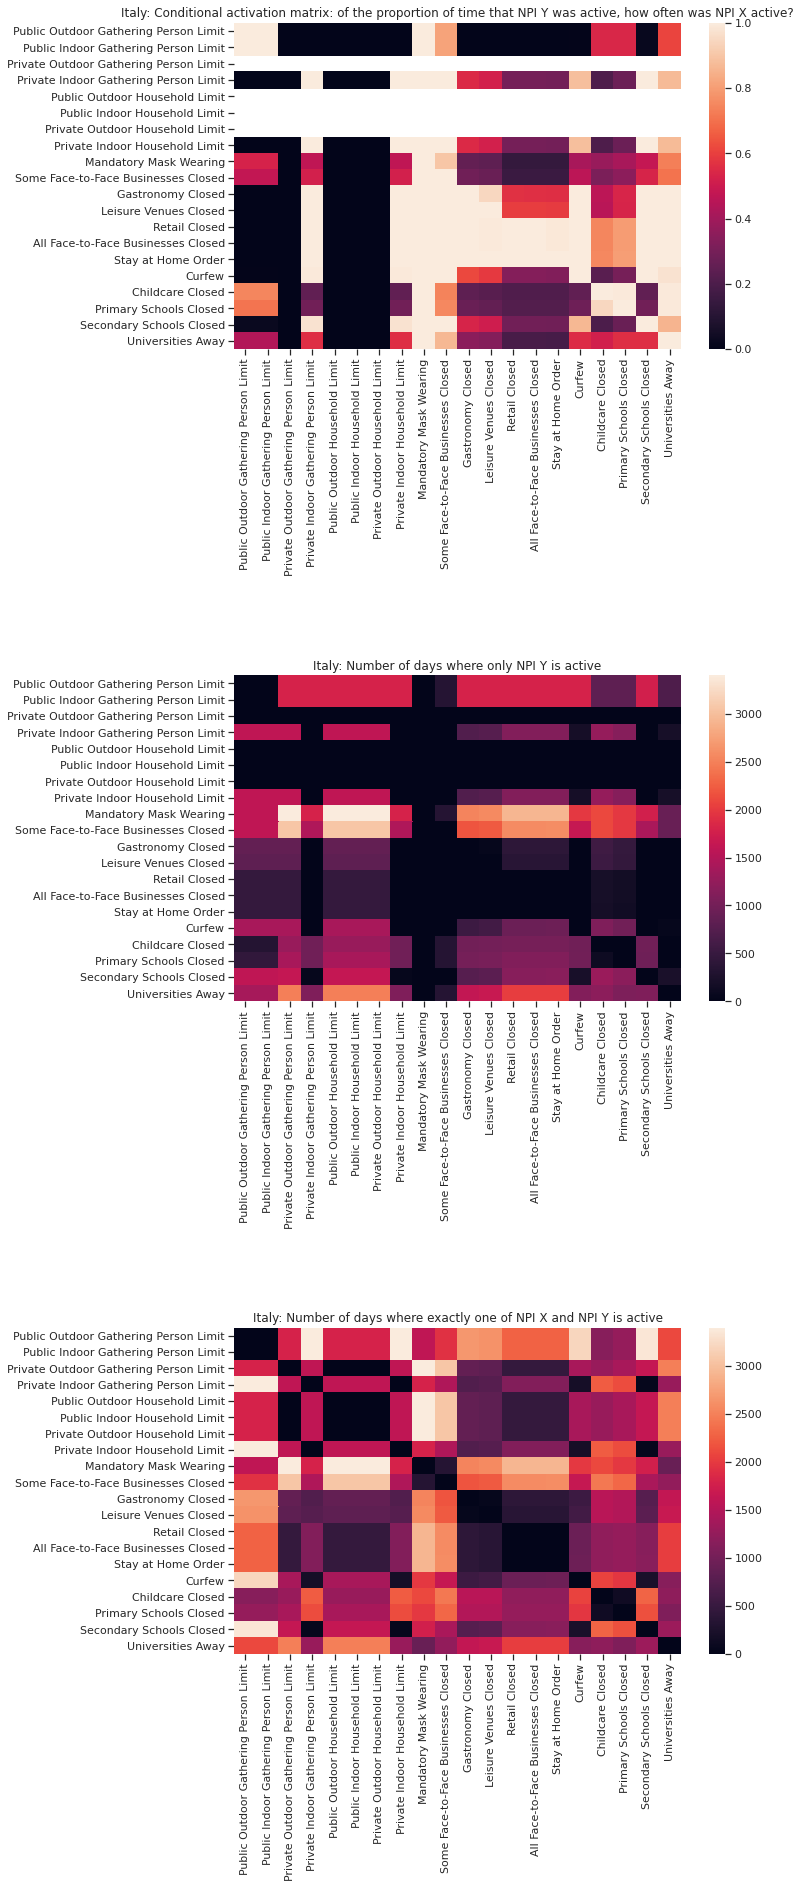

In [40]:
conditional_activation_plotter('Italy')

## Paired Activation Differences

In [41]:
def get_start_dates(data, npi, region):
    df_region = data[data['Area']==region]
    start_dates = []
    if list(df_region[npi])[0] != 0:
        start_dates.append(0)
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last == 0 and next != 0:
            start_dates.append(i)
        last = next
    return start_dates

def compare_dates(ds1, ds2):
    diffs = []
    for d1 in ds1:
        for d2 in ds2:
            diffs.append(d1 - d2)
    return diffs

def compute_start_dates(data):
    starts = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            starts[npi1, npi2] = []
            for region in np.unique(data['Area']):
                starts[npi1, npi2].append(compare_dates(get_start_dates(data, CMs[npi1], region),get_start_dates(data, CMs[npi2], region)))
            starts[npi1, npi2] = [diff for diffs in starts[npi1, npi2] for diff in diffs]
    return starts

def extract_diff_population(difference_data, threshold):
    count_data = np.zeros_like(difference_data)
    for i in range(count_data.shape[0]):
        for j in range(count_data.shape[1]):
            diff_reduced = [diff for diff in difference_data[i, j] if abs(diff) < threshold]
            count_data[i,j] = len(diff_reduced)
    return count_data

def get_end_dates(data, npi, region):
    df_region = data[data['Area']==region]
    end_dates = []
    #loop through list and find date when go from 0 to non-zero
    last = list(df_region[npi])[0]
    for i in range(1, df_region.shape[0]):
        next = list(df_region[npi])[i]
        if last != 0 and next == 0:
            end_dates.append(i)
        last = next
    return end_dates

def compute_end_dates(data):
    ends = np.empty((len(CMs), len(CMs)), dtype=object)
    for npi1 in range(len(CMs)):
        for npi2 in range(len(CMs)):
            ends[npi1, npi2] = []
            for region in np.unique(data['Area']):
                ends[npi1, npi2].append(compare_dates(get_end_dates(data, CMs[npi1], region),get_end_dates(data, CMs[npi2], region)))
            ends[npi1, npi2] = [diff for diffs in ends[npi1, npi2] for diff in diffs]
    return ends

In [42]:
starts = compute_start_dates(df)
# np.save('../data/npi_paired_activations', starts)

In [43]:
ends = compute_end_dates(df)
# np.save('../data/npi_paired_deactivations', ends)

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair activate at exactly the same time?')

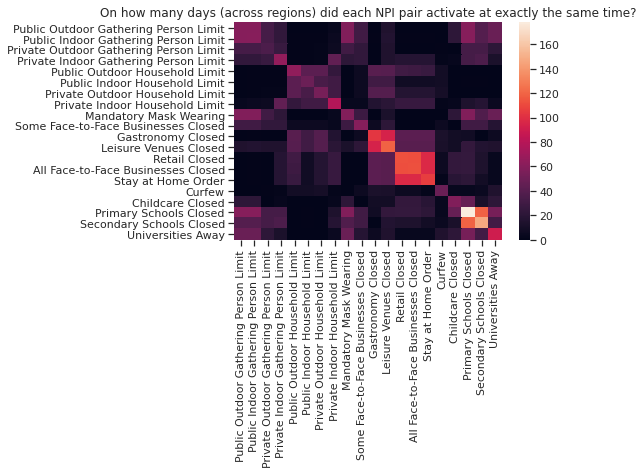

In [44]:
starts_extracted = extract_diff_population(starts, 0.5)
sns.heatmap(pd.DataFrame(starts_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate at exactly the same time?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair activate within 5 days of each other?')

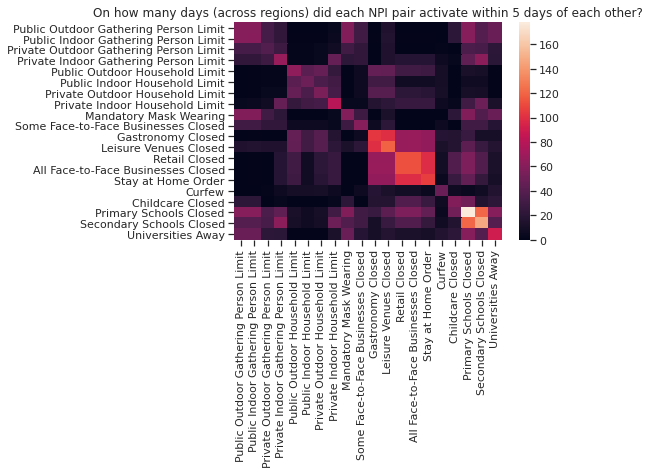

In [45]:
starts_extracted_5 = extract_diff_population(starts, 5)
sns.heatmap(pd.DataFrame(starts_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair activate within 5 days of each other?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair deactive at exactly the same time?')

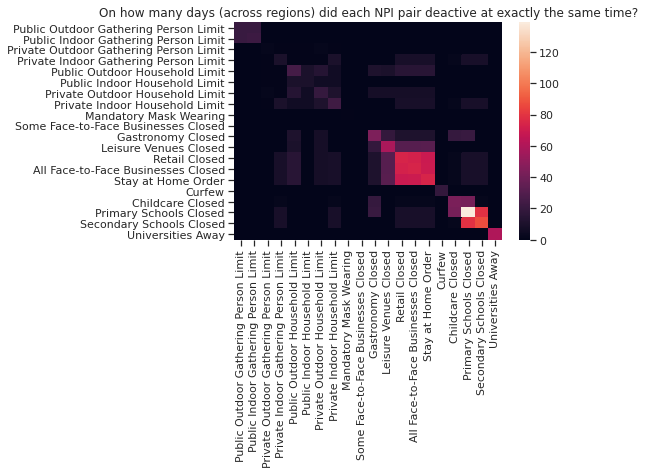

In [46]:
ends_extracted = extract_diff_population(ends, 0.5)
sns.heatmap(pd.DataFrame(ends_extracted, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive at exactly the same time?')

Text(0.5, 1.0, 'On how many days (across regions) did each NPI pair deactive within 5 days of each other?')

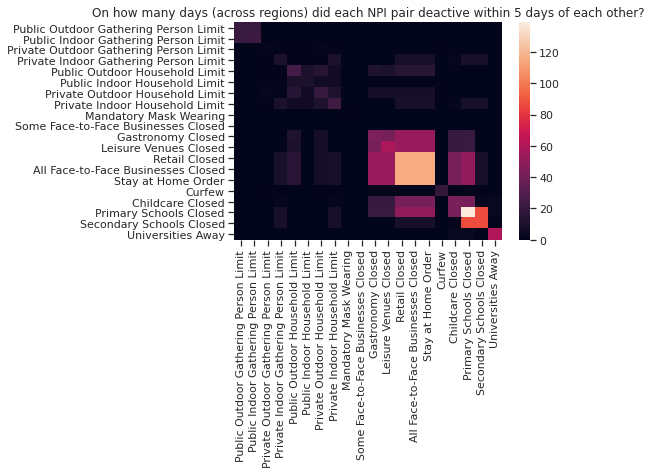

In [47]:
ends_extracted_5 = extract_diff_population(ends, 5)
sns.heatmap(pd.DataFrame(ends_extracted_5, dtype=float), xticklabels = CMs, yticklabels = CMs).set_title('On how many days (across regions) did each NPI pair deactive within 5 days of each other?')

### Country-specific joint activation/deactivation

In [48]:
df_uk = df[df['Country']=='England']
df_de = df[df['Country']=='Germany']
df_it = df[df['Country']=='Italy']
df_at = df[df['Country']=='Austria']

In [49]:
starts_uk = compute_start_dates(df_uk)
ends_uk = compute_end_dates(df_uk)
starts_de = compute_start_dates(df_de)
ends_de = compute_end_dates(df_de)
starts_it = compute_start_dates(df_it)
ends_it = compute_end_dates(df_it)
starts_at = compute_start_dates(df_at)
ends_at = compute_end_dates(df_at)
starts_countries = [starts_at, starts_uk, starts_de, starts_it]
ends_countries = [ends_at, ends_uk, ends_de, ends_it]

In [50]:
def plot_joint_activation_heatmap(data, country, threshold, activate, ax):
    extracted = extract_diff_population(data, threshold)
    sns.heatmap(pd.DataFrame(extracted, dtype=float), xticklabels = CMs, yticklabels = CMs, ax=ax).set_title('On how many days across regions in '+ country + ' did each NPI pair '+activate+' within '+ str(threshold) + ' days of one another?')
def plot_all_joint_activation_heatmaps(threshold, activate = 'activate'):
    fig = plt.figure(figsize=((10,40)))
    fig.subplots_adjust(hspace=1)
    fig_number = 0
    for country in np.unique(df['Country']):
        fig_number += 1
        ax = fig.add_subplot(4, 1, fig_number)
        if activate=='activate':
            data = starts_countries
        else:
            data = ends_countries
        plot_joint_activation_heatmap(data[fig_number-1], country, threshold, activate, ax = ax)
    plt.show()

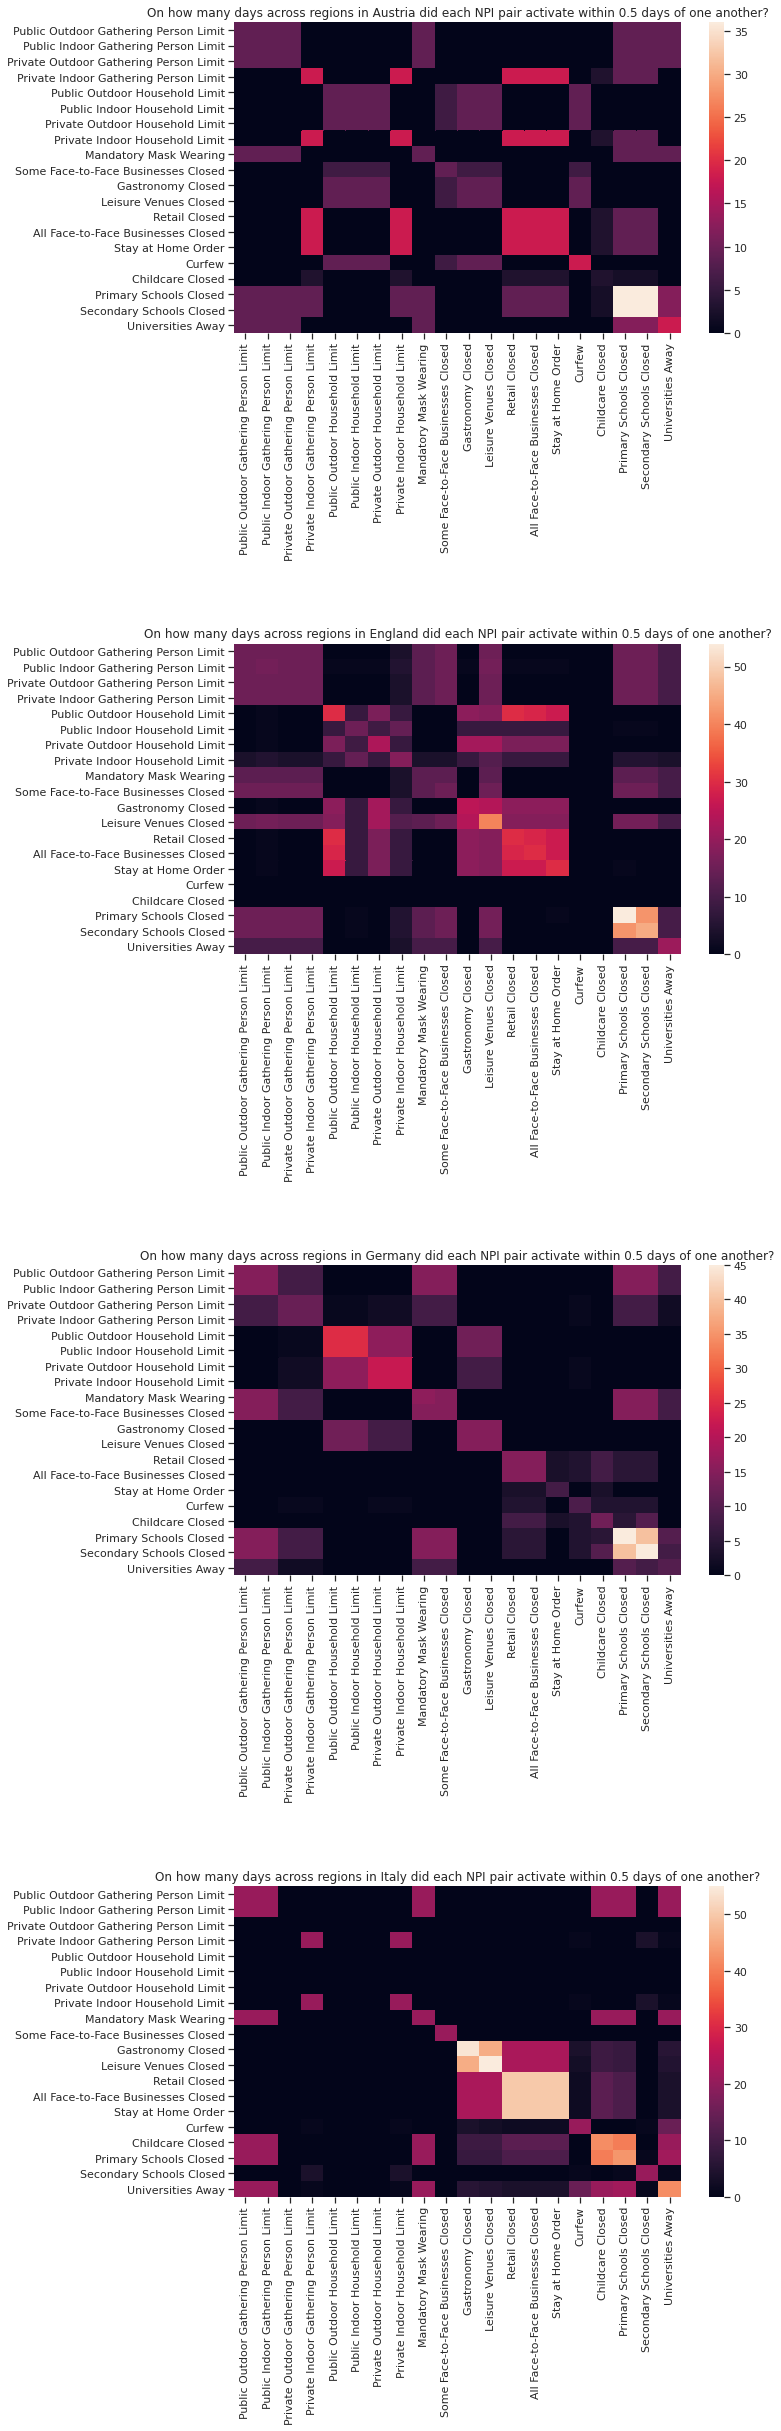

In [51]:
plot_all_joint_activation_heatmaps(0.5)

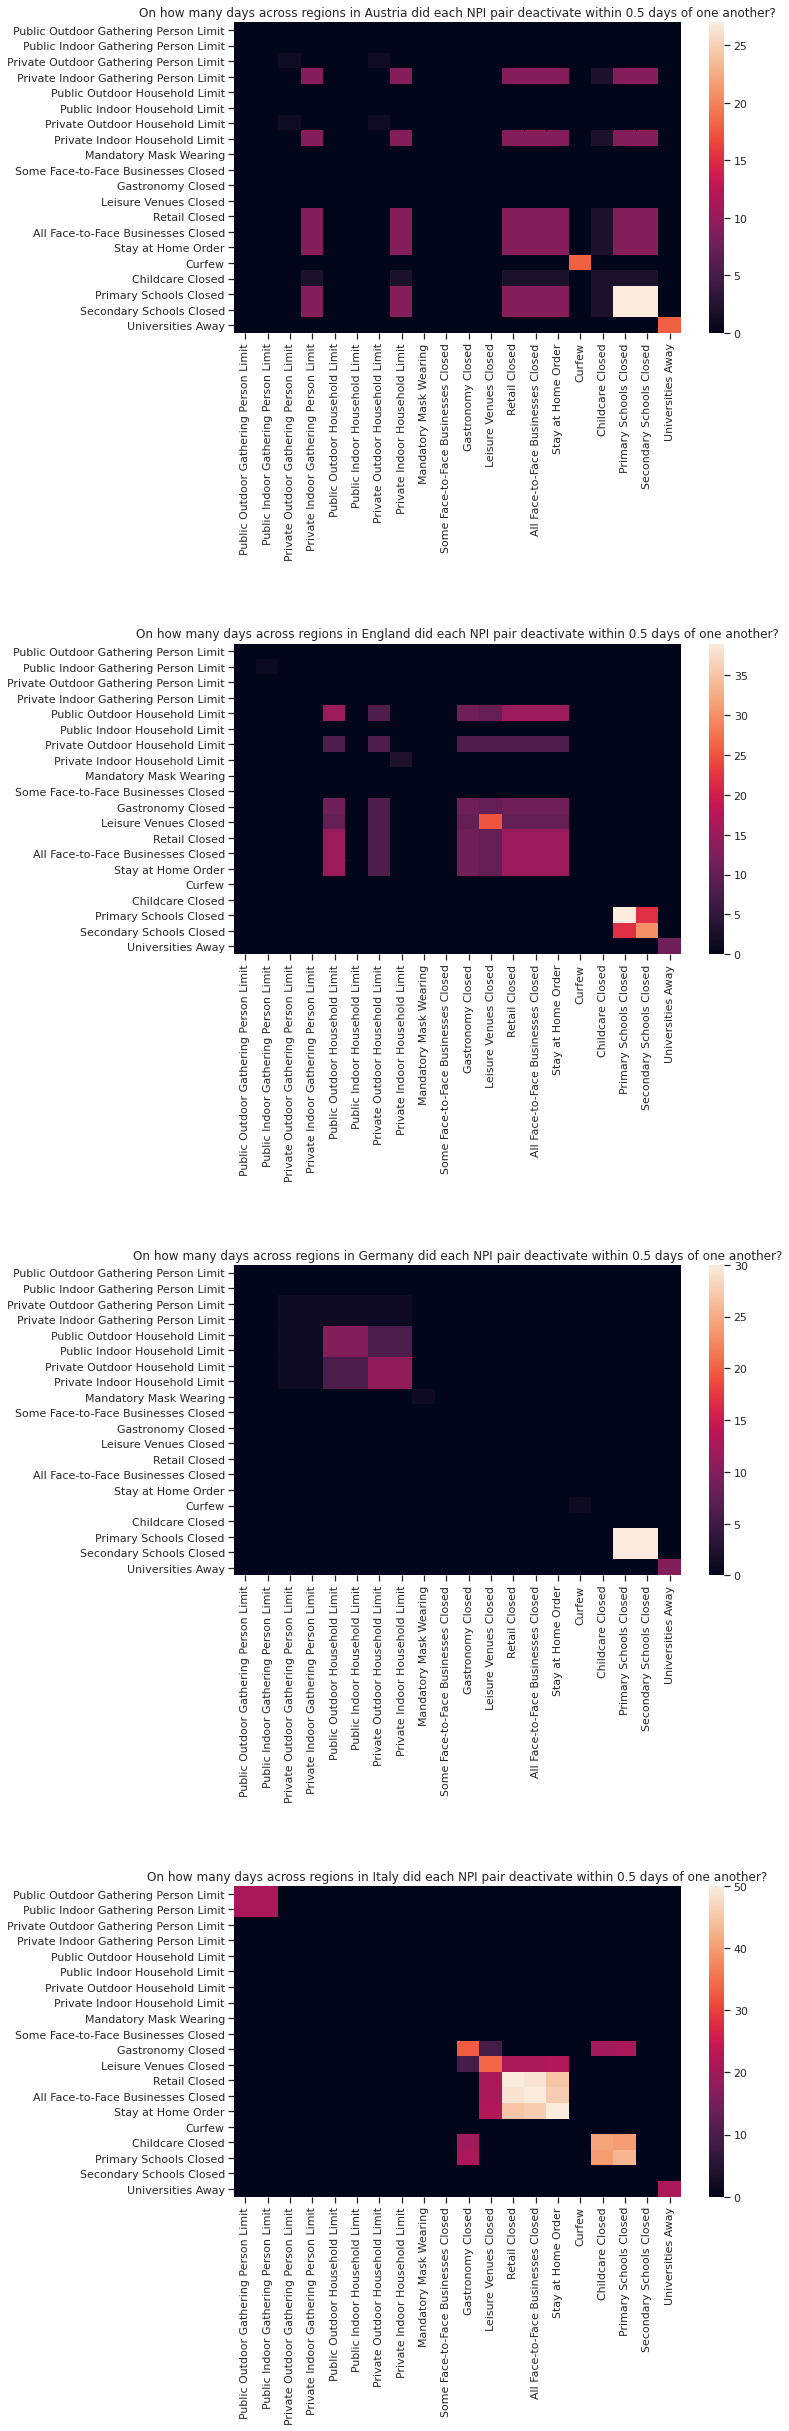

In [52]:
plot_all_joint_activation_heatmaps(0.5, 'deactivate')

In [53]:
# def plot_histogram_pairs(difference_data, threshold):
#     difference_data = pd.DataFrame(difference_data)
#     difference_data.columns = CMs
#     difference_data.index = CMs
#     fig = plt.figure(figsize=((150,100)))
#     fig_number = 0
#     for npi1 in range(len(CMs)):
#         for npi2 in range(len(CMs)):
#             fig_number += 1
#             ax = fig.add_subplot(20, 20, fig_number)
#             #plt.xticks(rotation=90)
#             sns.countplot(x = CMs[npi1], data = difference_data[CMs[npi2]], ax=ax)
#     pl.suptitle("")
#     plt.show()


